In [1]:
%matplotlib inline



The :class:`Raw <mne.io.Raw>` data structure: continuous data
=============================================================



In [2]:
from __future__ import print_function

import mne
import os.path as op
from matplotlib import pyplot as plt

# Load an example dataset, the preload flag loads the data into memory now
data_path = op.join(mne.datasets.sample.data_path(), 'MEG',
                    'sample', 'sample_audvis_raw.fif')

Continuous data is stored in objects of type :class:`Raw <mne.io.Raw>`.
The core data structure is simply a 2D numpy array (channels × samples,
stored in a private attribute called `._data`) combined with an
:class:`Info <mne.Info>` object (`.info` attribute)
(see `tut_info_objects`).

The most common way to load continuous data is from a .fif file. For more
information on `loading data from other formats <ch_convert>`, or
creating it `from scratch <tut_creating_data_structures>`.



Loading continuous data
-----------------------



In [3]:

raw = mne.io.read_raw_fif(data_path, preload=True, add_eeg_ref=False)
raw.set_eeg_reference()  # set EEG average reference

# Give the sample rate
print(raw.info)
print('sample rate:', raw.info['sfreq'], 'Hz')
# Give the size of the data matrix
print('channels x samples:', raw._data.shape)

Opening raw data file /home/jmperez/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Adding average EEG reference projection.
1 projection items deactivated
<Info | 25 non-empty fields
    acq_pars : unicode | 13886 items
    bads : list | MEG 2443, EEG 053
    buffer_size_sec : numpy.float64 | 0.998976065792
    ch_names : list | MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, ...
    chs : list | 376 items (EOG: 1, EEG: 60, STIM: 9, GRAD: 204, MAG: 102)
    comps : list | 0 items
    custom_ref_applied : bool | False
    description : unicode | 49 items
    dev_head_t : 'mne.transforms.Transform | 3 items
    dig : list | 146 items
    events : list | 1 items
    experimenter : unicode 

<div class="alert alert-info"><h4>Note</h4><p>Accessing the `._data` attribute is done here for educational
          purposes. However this is a private attribute as its name starts
          with an `_`. This suggests that you should **not** access this
          variable directly but rely on indexing syntax detailed just below.</p></div>



Information about the channels contained in the :class:`Raw <mne.io.Raw>`
object is contained in the :class:`Info <mne.Info>` attribute.
This is essentially a dictionary with a number of relevant fields (see
`tut_info_objects`).



Indexing data
-------------

To access the data stored within :class:`Raw <mne.io.Raw>` objects,
it is possible to index the :class:`Raw <mne.io.Raw>` object.

Indexing a :class:`Raw <mne.io.Raw>` object will return two arrays: an array
of times, as well as the data representing those timepoints. This works
even if the data is not preloaded, in which case the data will be read from
disk when indexing. The syntax is as follows:



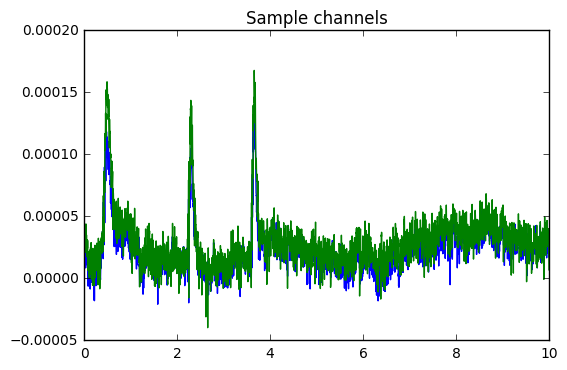

In [4]:
# Extract data from the first 5 channels, from 1 s to 3 s.
sfreq = raw.info['sfreq']

def plot_channel(raw, channel, start, end):
    data, times = raw[channel, int(sfreq * start):int(sfreq * end)]

    _ = plt.plot(times, data.T)
    _ = plt.title('Sample channels')


plot_channel(raw, 320, start=0, end=10)
plot_channel(raw, 321, start=0, end=10)




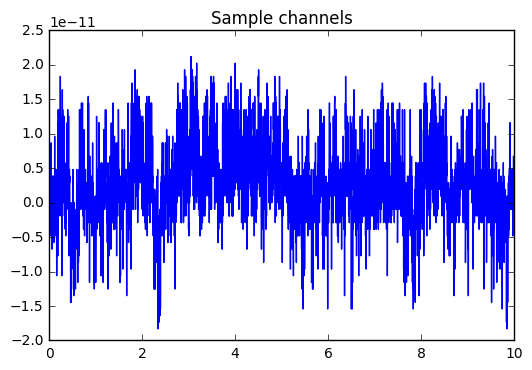

In [5]:
plot_channel(raw, 100, start=0, end=10)

-----------------------------------------
Selecting subsets of channels and samples
-----------------------------------------

It is possible to use more intelligent indexing to extract data, using
channel names, types or time ranges.



In [7]:
# Pull all MEG gradiometer channels:
# Make sure to use .copy() or it will overwrite the data
meg_only = raw.copy().pick_types(meg=True)
eeg_only = raw.copy().pick_types(meg=False, eeg=True)

# The MEG flag in particular lets you specify a string for more specificity
grad_only = raw.copy().pick_types(meg='grad')

# Or you can use custom channel names
pick_chans = ['MEG 0112', 'MEG 0111', 'MEG 0122', 'MEG 0123']
specific_chans = raw.copy().pick_channels(pick_chans)
print(meg_only, eeg_only, grad_only, specific_chans, sep='\n')

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 305 x 166800 (277.7 sec), ~391.8 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 59 x 166800 (277.7 sec), ~78.2 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 203 x 166800 (277.7 sec), ~261.8 MB, data loaded>
<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 4 x 166800 (277.7 sec), ~8.1 MB, data loaded>


Notice the different scalings of these types



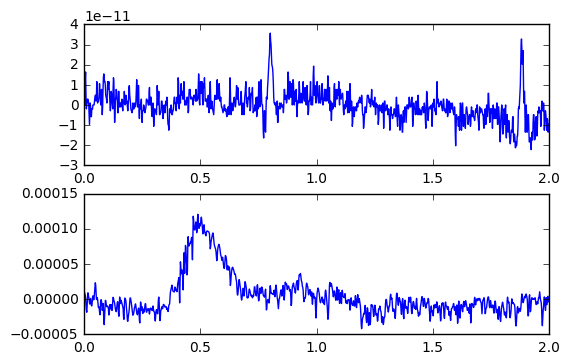

In [8]:
f, (a1, a2) = plt.subplots(2, 1)
eeg, times = eeg_only[0, :int(sfreq * 2)]
meg, times = meg_only[0, :int(sfreq * 2)]
a1.plot(times, meg[0])
a2.plot(times, eeg[0])
#del eeg, meg, meg_only, grad_only, eeg_only, specific_chans

You can restrict the data to a specific time range



In [9]:
raw = raw.crop(0, 50)  # in seconds
print('New time range from', raw.times.min(), 's to', raw.times.max(), 's')

New time range from 0.0 s to 50.000417053 s


And drop channels by name



In [10]:
nchan = raw.info['nchan']
raw = raw.drop_channels(['MEG 0241', 'EEG 001'])
print('Number of channels reduced from', nchan, 'to', raw.info['nchan'])

Number of channels reduced from 376 to 374


--------------------------------------------------
Concatenating :class:`Raw <mne.io.Raw>` objects
--------------------------------------------------

:class:`Raw <mne.io.Raw>` objects can be concatenated in time by using the
:func:`append <mne.io.Raw.append>` function. For this to work, they must
have the same number of channels and their :class:`Info
<mne.Info>` structures should be compatible.



In [12]:
# Create multiple :class:`Raw <mne.io.RawFIF>` objects
raw1 = raw.copy().crop(0, 10)
raw2 = raw.copy().crop(10, 20)
raw3 = raw.copy().crop(20, 40)

# Concatenate in time (also works without preloading)
raw1.append([raw2, raw3])
print('Time extends from', raw1.times.min(), 's to', raw1.times.max(), 's')

Time extends from 0.0 s to 40.0039965546 s


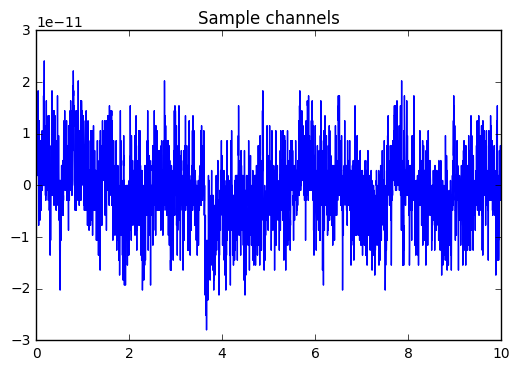

In [26]:
plot_channel(raw, 50, 0, 10)

71 events found
Events id: [ 1  2  3  4  5 32]
70 events found
Events id: [ 1  2  3  4  5 32]
Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.


<ipython-input-25-1eca9df6f277>:3: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  raw_copy.resample(50)


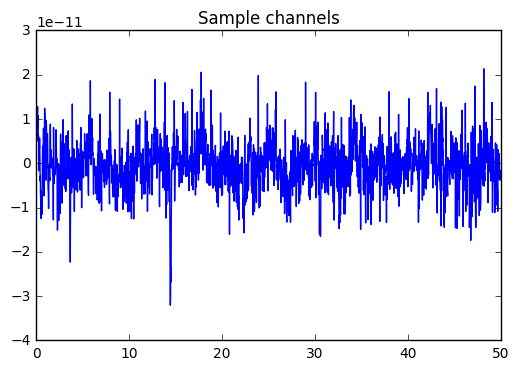

In [25]:
raw_copy = raw.copy()

raw_copy.resample(50)

plot_channel(raw_copy, 3, 0, 10)